In [12]:
from math import sqrt
import pandas as pd
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM
from numpy import concatenate

In [13]:
df = pd.read_csv('/Users/alexellard/Downloads/scenarios_data.csv', header=0, index_col=0)
df

,reservoir_demand,node_1_demand,node_2_demand,node_3_demand,node_4_demand,node_5_demand,node_6_demand,node_7_demand,node_8_demand,node_9_demand,...,link_23_flow,link_24_flow,link_25_flow,link_26_flow,link_27_flow,link_28_flow,link_29_flow,link_30_flow,link_31_flow,link_32_flow
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-3348.0,154.8,169.2,18.0,118.8,169.2,234.0,86.4,82.8,104.4,...,439.2,-205.2,-75.6,-18.0,118.8,68.4,7.2,-54.0,75.6,212.4
2017-01-01 00:30:00,-2959.2,136.8,147.6,18.0,108.0,144.0,237.6,79.2,75.6,90.0,...,392.4,-187.2,-72.0,-21.6,108.0,61.2,3.6,-54.0,72.0,183.6
2017-01-01 01:00:00,-2692.8,129.6,126.0,14.4,104.4,133.2,205.2,72.0,72.0,90.0,...,349.2,-176.4,-64.8,-18.0,93.6,50.4,3.6,-39.6,54.0,151.2
2017-01-01 01:30:00,-2379.6,104.4,100.8,10.8,86.4,122.4,180.0,68.4,57.6,82.8,...,316.8,-158.4,-54.0,-10.8,79.2,46.8,7.2,-32.4,50.4,140.4
2017-01-01 02:00:00,-2228.4,104.4,104.4,10.8,79.2,122.4,183.6,68.4,54.0,75.6,...,277.2,-144.0,-57.6,-18.0,72.0,39.6,7.2,-32.4,43.2,118.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 21:30:00,-5306.4,205.2,208.8,39.6,183.6,284.4,316.8,176.4,133.2,129.6,...,604.8,-259.2,32.4,115.2,169.2,100.8,10.8,-100.8,122.4,309.6
2017-12-31 22:00:00,-4910.4,208.8,183.6,39.6,154.8,252.0,295.2,165.6,133.2,133.2,...,565.2,-241.2,21.6,100.8,154.8,86.4,18.0,-75.6,100.8,288.0
2017-12-31 22:30:00,-4683.6,187.2,183.6,36.0,147.6,230.4,320.4,147.6,118.8,126.0,...,529.2,-226.8,21.6,100.8,147.6,86.4,14.4,-86.4,108.0,266.4


In [14]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, vars_to_predict=None):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i-1))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(n_out):
        cols.append(df[vars_to_predict].shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in vars_to_predict]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in vars_to_predict]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# node 1 indexes
target_variable_demand_node1 = [1]
target_variable_pressures_node1 = [33]
target_variable_flows_node1 = [64]

reframed_demand_node1 = series_to_supervised(scaled, 1, 1, vars_to_predict=target_variable_demand_node1)
reframed_pressures_node1 = series_to_supervised(scaled, 1, 1, vars_to_predict=target_variable_pressures_node1)
reframed_flows_node1 = series_to_supervised(scaled, 1, 1, vars_to_predict=target_variable_flows_node1)

reframed_demand_node1 = reframed_demand_node1.drop(reframed_demand_node1.columns[1], axis=1)
reframed_pressures_node1 = reframed_pressures_node1.drop(reframed_pressures_node1.columns[33], axis=1)
reframed_flows_node1 = reframed_flows_node1.drop(reframed_flows_node1.columns[64], axis=1)

(70080, 1, 95) (70080,) (17520, 1, 95) (17520,)
Train on 70080 samples, validate on 17520 samples
Epoch 1/50
 - 7s - loss: 0.0303 - val_loss: 0.0257
Epoch 2/50
 - 5s - loss: 0.0233 - val_loss: 0.0216
Epoch 3/50
 - 5s - loss: 0.0225 - val_loss: 0.0220
Epoch 4/50
 - 5s - loss: 0.0223 - val_loss: 0.0217
Epoch 5/50
 - 7s - loss: 0.0222 - val_loss: 0.0213
Epoch 6/50
 - 8s - loss: 0.0221 - val_loss: 0.0218
Epoch 7/50
 - 9s - loss: 0.0219 - val_loss: 0.0214
Epoch 8/50
 - 6s - loss: 0.0219 - val_loss: 0.0214
Epoch 9/50
 - 8s - loss: 0.0218 - val_loss: 0.0214
Epoch 10/50
 - 6s - loss: 0.0218 - val_loss: 0.0216
Epoch 11/50
 - 6s - loss: 0.0217 - val_loss: 0.0214
Epoch 12/50
 - 6s - loss: 0.0216 - val_loss: 0.0213
Epoch 13/50
 - 6s - loss: 0.0216 - val_loss: 0.0212
Epoch 14/50
 - 6s - loss: 0.0215 - val_loss: 0.0214
Epoch 15/50
 - 6s - loss: 0.0215 - val_loss: 0.0211
Epoch 16/50
 - 6s - loss: 0.0215 - val_loss: 0.0211
Epoch 17/50
 - 6s - loss: 0.0215 - val_loss: 0.0214
Epoch 18/50
 - 7s - loss: 0

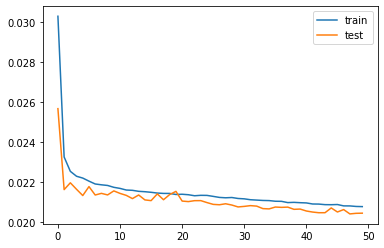

In [21]:
# split into train and test sets
demand_values = reframed_demand_node1.values
train, test = train_test_split(demand_values, test_size=0.2, random_state=0)

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [22]:
# make predictions on the test data
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

test_y = test_y.reshape((len(test_y), 1))
inv_test_y = concatenate((test_y, test_X[:, -96:]), axis=1)
test_y_inverse = scaler.inverse_transform(inv_test_y)
test_y_inverse = test_y_inverse[:,0]

y_pred = y_pred.reshape((len(y_pred), 1))
inv_y_pred = concatenate((y_pred, test_X[:, -96:]), axis=1)
y_pred_inverse = scaler.inverse_transform(inv_y_pred)
y_pred_inverse = y_pred_inverse[:,0]

# evaluate scaled errors
mae = mean_absolute_error(test_y_inverse, y_pred_inverse)
print('Inverted Mean Absolute Error:', mae)
rmse = sqrt(mean_squared_error(test_y_inverse, y_pred_inverse))
print('Inverted Test RMSE: %.3f' % rmse)
r2 = r2_score(test_y_inverse, y_pred_inverse)
print('Inverted Test R^2: %.3f' % r2)

Inverted Mean Absolute Error: 174.53339
Inverted Test RMSE: 228.282
Inverted Test R^2: 0.973


(70080, 1, 95) (70080,) (17520, 1, 95) (17520,)
Train on 70080 samples, validate on 17520 samples
Epoch 1/50
 - 7s - loss: 0.0254 - val_loss: 0.0095
Epoch 2/50
 - 5s - loss: 0.0083 - val_loss: 0.0064
Epoch 3/50
 - 5s - loss: 0.0064 - val_loss: 0.0059
Epoch 4/50
 - 5s - loss: 0.0054 - val_loss: 0.0048
Epoch 5/50
 - 6s - loss: 0.0047 - val_loss: 0.0042
Epoch 6/50
 - 6s - loss: 0.0047 - val_loss: 0.0064
Epoch 7/50
 - 5s - loss: 0.0042 - val_loss: 0.0083
Epoch 8/50
 - 6s - loss: 0.0039 - val_loss: 0.0026
Epoch 9/50
 - 5s - loss: 0.0038 - val_loss: 0.0029
Epoch 10/50
 - 6s - loss: 0.0034 - val_loss: 0.0026
Epoch 11/50
 - 6s - loss: 0.0034 - val_loss: 0.0041
Epoch 12/50
 - 5s - loss: 0.0031 - val_loss: 0.0043
Epoch 13/50
 - 6s - loss: 0.0030 - val_loss: 0.0070
Epoch 14/50
 - 5s - loss: 0.0028 - val_loss: 0.0025
Epoch 15/50
 - 5s - loss: 0.0027 - val_loss: 0.0046
Epoch 16/50
 - 5s - loss: 0.0026 - val_loss: 0.0039
Epoch 17/50
 - 6s - loss: 0.0025 - val_loss: 0.0037
Epoch 18/50
 - 6s - loss: 0

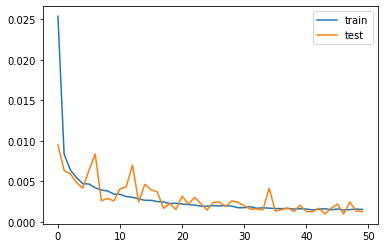

In [23]:
# split into train and test sets
pressure_values = reframed_pressures_node1.values
train, test = train_test_split(pressure_values, test_size=0.2, random_state=0)

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [24]:
# make predictions on the test data
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

test_y = test_y.reshape((len(test_y), 1))
inv_test_y = concatenate((test_y, test_X[:, -96:]), axis=1)
test_y_inverse = scaler.inverse_transform(inv_test_y)
test_y_inverse = test_y_inverse[:,0]

y_pred = y_pred.reshape((len(y_pred), 1))
inv_y_pred = concatenate((y_pred, test_X[:, -96:]), axis=1)
y_pred_inverse = scaler.inverse_transform(inv_y_pred)
y_pred_inverse = y_pred_inverse[:,0]

# evaluate scaled errors
mae = mean_absolute_error(test_y_inverse, y_pred_inverse)
print('Inverted Mean Absolute Error:', mae)
rmse = sqrt(mean_squared_error(test_y_inverse, y_pred_inverse))
print('Inverted Test RMSE: %.3f' % rmse)
r2 = r2_score(test_y_inverse, y_pred_inverse)
print('Inverted Test R^2: %.3f' % r2)

Inverted Mean Absolute Error: 10.801796
Inverted Test RMSE: 14.946
Inverted Test R^2: 1.000


(70080, 1, 95) (70080,) (17520, 1, 95) (17520,)
Train on 70080 samples, validate on 17520 samples
Epoch 1/50
 - 7s - loss: 0.0081 - val_loss: 0.0056
Epoch 2/50
 - 6s - loss: 0.0037 - val_loss: 0.0018
Epoch 3/50
 - 6s - loss: 0.0031 - val_loss: 0.0021
Epoch 4/50
 - 6s - loss: 0.0030 - val_loss: 0.0056
Epoch 5/50
 - 5s - loss: 0.0028 - val_loss: 0.0019
Epoch 6/50
 - 5s - loss: 0.0028 - val_loss: 0.0027
Epoch 7/50
 - 5s - loss: 0.0022 - val_loss: 0.0043
Epoch 8/50
 - 5s - loss: 0.0021 - val_loss: 8.8577e-04
Epoch 9/50
 - 5s - loss: 0.0022 - val_loss: 0.0039
Epoch 10/50
 - 5s - loss: 0.0023 - val_loss: 0.0012
Epoch 11/50
 - 5s - loss: 0.0020 - val_loss: 0.0011
Epoch 12/50
 - 5s - loss: 0.0016 - val_loss: 0.0048
Epoch 13/50
 - 5s - loss: 0.0019 - val_loss: 0.0018
Epoch 14/50
 - 5s - loss: 0.0015 - val_loss: 0.0022
Epoch 15/50
 - 5s - loss: 0.0017 - val_loss: 0.0016
Epoch 16/50
 - 5s - loss: 0.0014 - val_loss: 0.0012
Epoch 17/50
 - 5s - loss: 0.0015 - val_loss: 5.8404e-04
Epoch 18/50
 - 5s -

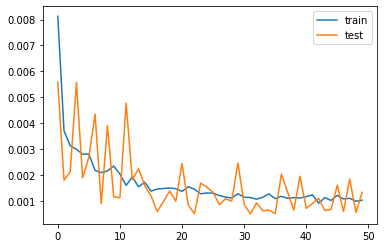

In [25]:
# split into train and test sets
flow_values = reframed_flows_node1.values
train, test = train_test_split(flow_values, test_size=0.2, random_state=0)

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [26]:
# make predictions on the test data
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

test_y = test_y.reshape((len(test_y), 1))
inv_test_y = concatenate((test_y, test_X[:, -96:]), axis=1)
test_y_inverse = scaler.inverse_transform(inv_test_y)
test_y_inverse = test_y_inverse[:,0]

y_pred = y_pred.reshape((len(y_pred), 1))
inv_y_pred = concatenate((y_pred, test_X[:, -96:]), axis=1)
y_pred_inverse = scaler.inverse_transform(inv_y_pred)
y_pred_inverse = y_pred_inverse[:,0]

# evaluate scaled errors
mae = mean_absolute_error(test_y_inverse, y_pred_inverse)
print('Inverted Mean Absolute Error:', mae)
rmse = sqrt(mean_squared_error(test_y_inverse, y_pred_inverse))
print('Inverted Test RMSE: %.3f' % rmse)
r2 = r2_score(test_y_inverse, y_pred_inverse)
print('Inverted Test R^2: %.3f' % r2)

Inverted Mean Absolute Error: 11.318494
Inverted Test RMSE: 12.400
Inverted Test R^2: 1.000
